✅ 데이터 로드 완료: CSV 및 ArUco JSON
--- 각 뷰/카메라 조합에 대한 대표 이미지 랜덤 선택 ---
  ✅ [left/leftcam] 선택 완료: zed_38007749_left_1748249372.014.jpg
  ✅ [left/rightcam] 선택 완료: zed_38007749_right_1748249200.779.jpg
  ✅ [right/leftcam] 선택 완료: zed_34850673_left_1748248983.969.jpg
  ✅ [right/rightcam] 선택 완료: zed_34850673_right_1748249381.429.jpg
  ✅ [top/leftcam] 선택 완료: zed_30779426_left_1748249387.336.jpg
  ✅ [top/rightcam] 선택 완료: zed_30779426_right_1748248640.618.jpg


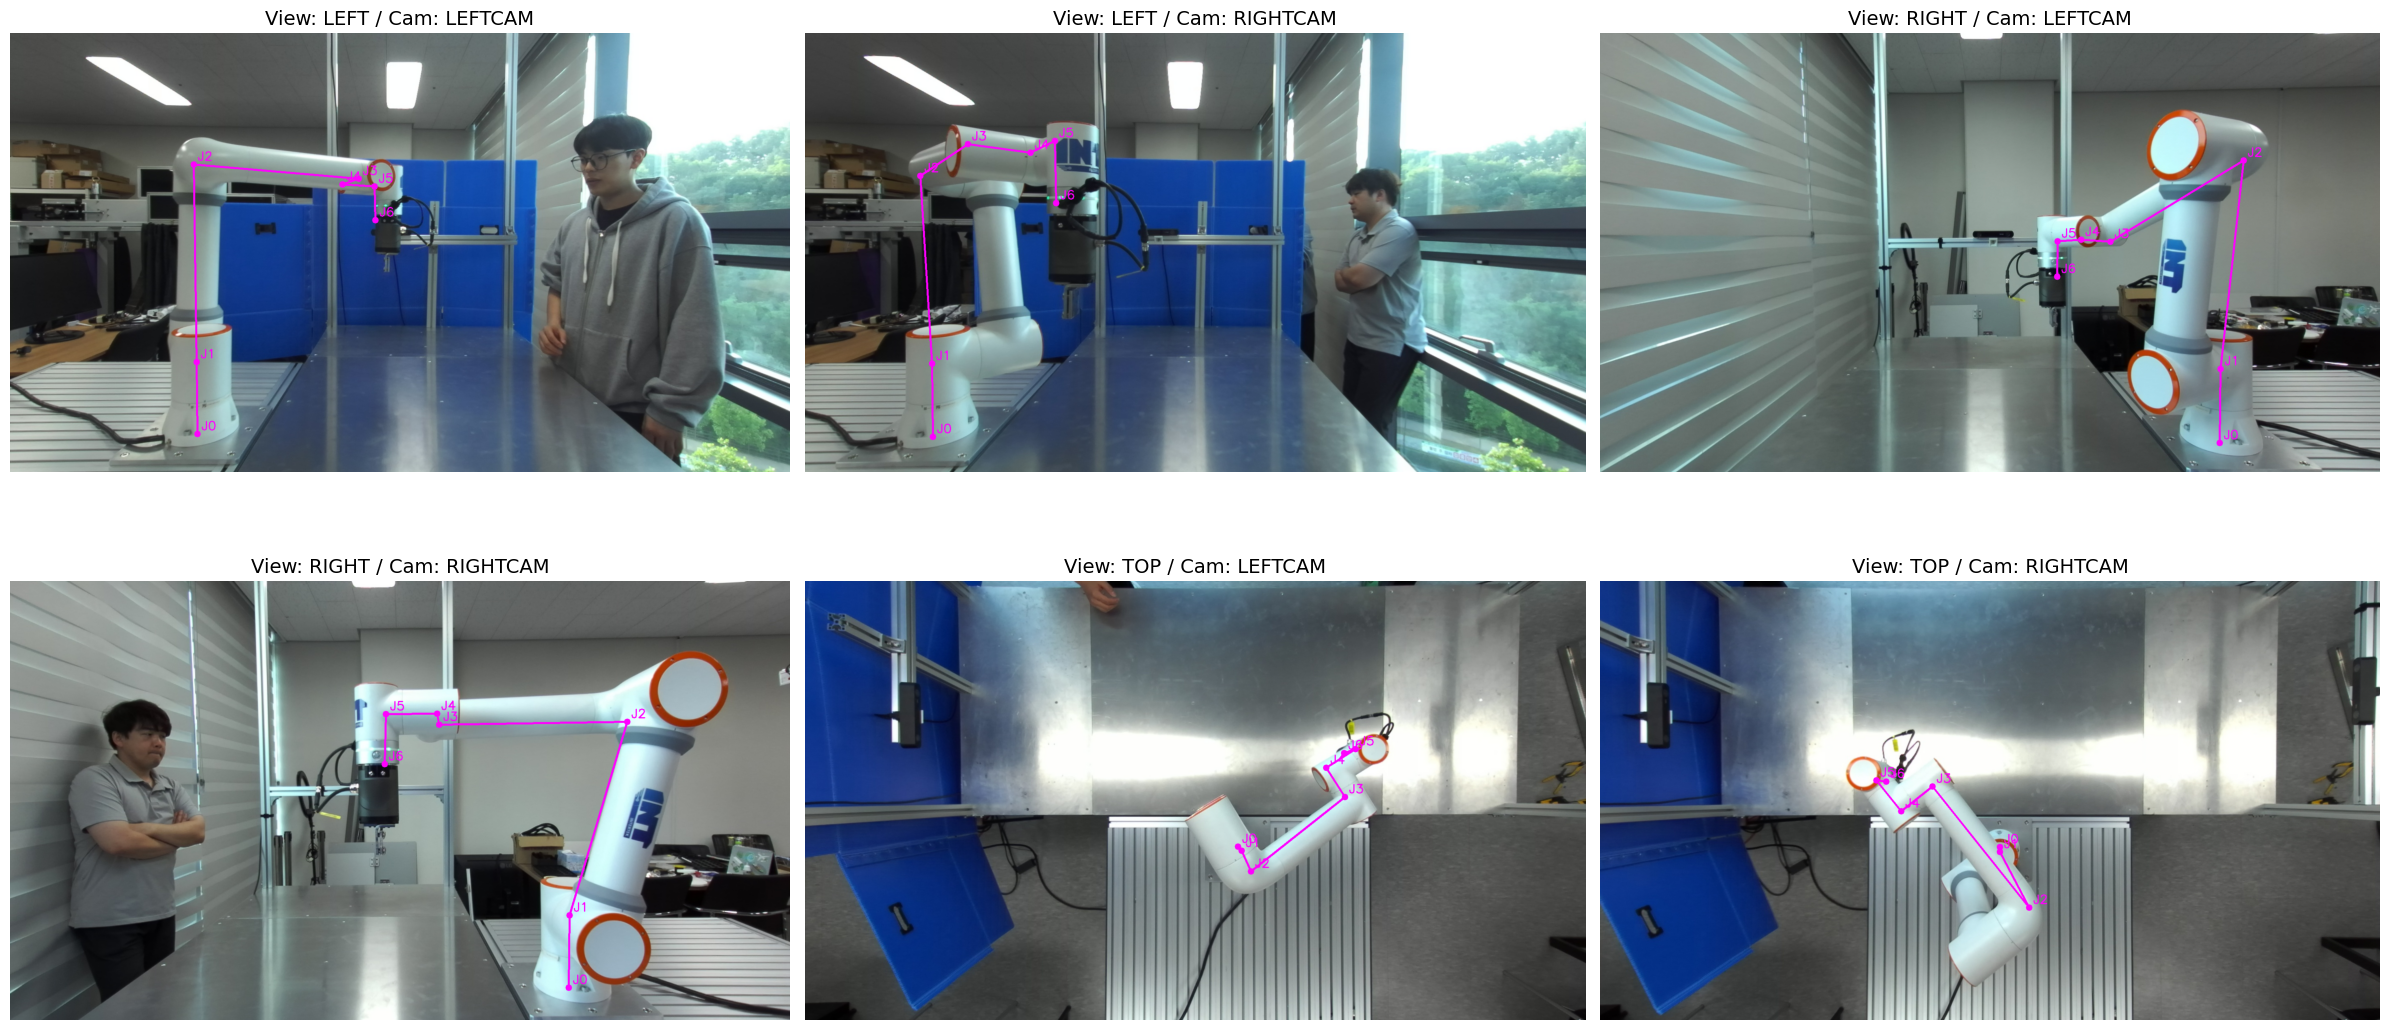

In [8]:
import os
import json
import math
import cv2
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R

# --- ⚙️ 1. 설정 변수 ---

# 동기화된 데이터 CSV 파일 경로
SYNC_CSV_PATH = "../dataset/Fr5/fr5_matched_joint_angle.csv"
# ArUco 마커 포즈 요약 파일 경로
ARUCO_JSON_PATH = "../dataset/Fr5/Fr5_aruco_pose_summary.json"
# 카메라 캘리브레이션 파일이 있는 디렉토리
CALIB_DIR = "../dataset/Fr5/Fr5_calib_cam_from_conf"

# 각 뷰 이름과 카메라 시리얼 번호 매핑
CAMERA_SERIALS = {
    "left": "38007749",
    "right": "34850673",
    "top": "30779426"
}

# --- 🛠️ 2. 헬퍼 함수 ---

def get_dh_matrix(a, d, alpha, theta):
    """표준 DH 파라미터를 사용하여 변환 행렬을 계산합니다. (각도는 degree 단위로 입력)"""
    alpha_rad = math.radians(alpha)
    theta_rad = math.radians(theta)
    return np.array([
        [np.cos(theta_rad), -np.sin(theta_rad) * np.cos(alpha_rad),  np.sin(theta_rad) * np.sin(alpha_rad), a * np.cos(theta_rad)],
        [np.sin(theta_rad),  np.cos(theta_rad) * np.cos(alpha_rad), -np.cos(theta_rad) * np.sin(alpha_rad), a * np.sin(theta_rad)],
        [0, np.sin(alpha_rad), np.cos(alpha_rad), d],
        [0, 0, 0, 1]
    ])

def angle_to_joint_coordinate(joint_angles, selected_view):
    """6개의 관절 각도(degree)를 순방향 기구학을 통해 3D 좌표로 변환합니다."""
    # FR5 로봇의 DH 파라미터 (단위: 미터, 도)
    fr5_dh_parameters = [
        {'alpha': 90,  'a': 0,      'd': 0.152, 'theta_offset': 0},
        {'alpha': 0,   'a': -0.425, 'd': 0,     'theta_offset': 0},
        {'alpha': 0,   'a': -0.395, 'd': 0,     'theta_offset': 0},
        {'alpha': 90,  'a': 0,      'd': 0.102, 'theta_offset': 0},
        {'alpha': -90, 'a': 0,      'd': 0.102, 'theta_offset': 0},
        {'alpha': 0,   'a': 0,      'd': 0.100, 'theta_offset': 0}
    ]
    
    # 카메라 뷰에 따른 로봇 베이스의 상대 회전
    view_rotations = {
        'top':   R.from_euler('zyx', [-85, 0, 180], degrees=True),
        'left':  R.from_euler('zyx', [180, 0, 90],  degrees=True),
        'right': R.from_euler('zyx', [0, 0, 90],    degrees=True)
    }
    
    T_base_correction = np.eye(4)
    if selected_view in view_rotations:
        T_base_correction[:3, :3] = view_rotations[selected_view].as_matrix()

    T_cumulative = T_base_correction
    joint_coords_3d = [np.array([0, 0, 0])] # J0 (베이스) 위치
    base_point = np.array([[0], [0], [0], [1]])

    for i in range(6):
        params = fr5_dh_parameters[i]
        theta = joint_angles[i] + params['theta_offset']
        T_i = get_dh_matrix(params['a'], params['d'], params['alpha'], theta)
        T_cumulative = T_cumulative @ T_i
        joint_pos = T_cumulative @ base_point
        joint_coords_3d.append(joint_pos[:3, 0])
        
    return np.array(joint_coords_3d, dtype=np.float32)

def project_to_pixel(coords_3d, rvec, tvec, camera_matrix, dist_coeffs):
    """3D 좌표를 2D 이미지 평면에 투영합니다."""
    # rvec과 tvec은 메인 루프에서 미리 준비하여 전달받습니다.
    pixel_coords, _ = cv2.projectPoints(coords_3d, rvec, tvec, camera_matrix, dist_coeffs)
    return pixel_coords.reshape(-1, 2)

# --- 🚀 3. 메인 실행 ---

def main():
    """
    동기화된 CSV 파일을 읽어, 각 뷰/카메라 조합에 대한 랜덤 이미지를 선택하고
    로봇 관절 데이터를 시각화합니다.
    """
    # --- 단계 1: 데이터 로드 ---
    try:
        df_sync = pd.read_csv(SYNC_CSV_PATH)
        with open(ARUCO_JSON_PATH, 'r') as f:
            aruco_results = json.load(f)
    except FileNotFoundError as e:
        print(f"❌ 에러: 필수 파일을 찾을 수 없습니다 - {e}")
        return

    print("✅ 데이터 로드 완료: CSV 및 ArUco JSON")

    # --- 단계 2: 시각화할 데이터 랜덤 선택 ---
    views_to_plot = ['left', 'right', 'top']
    cams_to_plot = ['leftcam', 'rightcam']
    selected_rows = []

    print("--- 각 뷰/카메라 조합에 대한 대표 이미지 랜덤 선택 ---")
    for view in views_to_plot:
        for cam in cams_to_plot:
            # ✨ 수정된 부분: 파일명에 맞는 short name(e.g., 'left')을 사용하여 검색
            cam_short_name = cam.replace("cam", "")
            
            matching_df = df_sync[
                df_sync['image_path'].str.contains(f"/{view}/") &
                df_sync['image_path'].str.contains(f"_{cam_short_name}_")
            ]
            
            if not matching_df.empty:
                selected_row = matching_df.sample(n=1).iloc[0]
                selected_rows.append(selected_row)
                img_name = os.path.basename(selected_row['image_path'])
                print(f"  ✅ [{view}/{cam}] 선택 완료: {img_name}")
            else:
                print(f"  ⚠️ [{view}/{cam}] 조합에 해당하는 데이터를 CSV에서 찾을 수 없습니다.")

    if not selected_rows:
        print("❌ 시각화할 데이터를 선택하지 못했습니다.")
        return
        
    # --- 단계 3: 선택된 데이터 시각화 ---
    fig, axes = plt.subplots(2, 3, figsize=(24, 12))
    axes = axes.flatten()

    for i, row in enumerate(selected_rows):
        ax = axes[i]
        
        # 뷰/캠 정보 초기화 (오류 발생 시 출력을 위함)
        view, cam = "N/A", "N/A" 
        try:
            image_path = row['image_path']
            
            # CSV에서 관절 데이터 추출 (joint_1 ~ joint_6)
            joint_angles = [row[f'joint_{j}'] for j in range(1, 7)]

            # 파일명에서 뷰와 캠 정보 파싱
            img_name = os.path.basename(image_path)
            parts = os.path.splitext(img_name)[0].split('_')
            view = [v for v in views_to_plot if f"/{v}/" in image_path][0]
            cam = parts[-2] + "cam"

            # 해당 뷰/캠에 맞는 ArUco 및 캘리브레이션 데이터 찾기
            aruco_result = next(item for item in aruco_results if item['view'] == view and item['cam'] == cam)
            
            serial = CAMERA_SERIALS[view]
            calib_path = os.path.join(CALIB_DIR, f"{view}_{serial}_{cam}_calib.json")
            with open(calib_path, 'r') as f:
                calib_data = json.load(f)

            # 이미지 로드 및 왜곡 보정
            image = cv2.imread(image_path)
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            camera_matrix = np.array(calib_data["camera_matrix"], dtype=np.float32)
            dist_coeffs = np.array(calib_data["distortion_coeffs"], dtype=np.float32)
            undistorted_img = cv2.undistort(image_rgb, camera_matrix, dist_coeffs)

            # ✨ 수정된 부분: 각 뷰에 맞는 Rvec, Tvec을 명시적으로 추출하고 변환합니다.
            rvec = np.array([
                math.radians(aruco_result['rvec_x']),
                math.radians(aruco_result['rvec_y']),
                math.radians(aruco_result['rvec_z'])
            ], dtype=np.float32)
            tvec = np.array([
                aruco_result['tvec_x'],
                aruco_result['tvec_y'],
                aruco_result['tvec_z']
            ], dtype=np.float32).reshape(3, 1)

            # 순방향 기구학 및 2D 투영
            joint_coords_3d = angle_to_joint_coordinate(joint_angles, view)
            # ✨ 수정된 부분: 명시적으로 추출된 rvec, tvec을 투영 함수에 전달합니다.
            pixel_coords = project_to_pixel(joint_coords_3d, rvec, tvec, camera_matrix, np.zeros_like(dist_coeffs))

            # 이미지에 로봇 스켈레톤 그리기
            font = cv2.FONT_HERSHEY_SIMPLEX
            for idx, (x, y) in enumerate(pixel_coords.astype(int)):
                cv2.circle(undistorted_img, (x, y), 8, (255, 0, 255), -1) # Magenta
                cv2.putText(undistorted_img, f"J{idx}", (x + 10, y - 10), font, 1.0, (255, 0, 255), 2)
                if idx > 0:
                    prev_x, prev_y = pixel_coords[idx-1].astype(int)
                    cv2.line(undistorted_img, (prev_x, prev_y), (x, y), (255, 0, 255), 3)

            ax.imshow(undistorted_img)
            ax.set_title(f"View: {view.upper()} / Cam: {cam.upper()}", fontsize=14)

        except Exception as e:
            print(f"❌ [{view}/{cam}] 시각화 중 오류 발생: {e}")
            ax.set_title(f"Error processing {view}/{cam}", color='red')
        finally:
            ax.axis("off")

    # 남은 subplot 비활성화
    for j in range(len(selected_rows), len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()


if __name__ == '__main__':
    main()

